In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

In [2]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:3


# Load the data

In [3]:
root_path = "/scratch/04703/sravula/UTAFSDataNew/new_data"
chip_num = 25

In [4]:
import utils

data_dict = utils.grab_chip_data(root_path, chip_num, resample=False)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Check the data matrices converted from touchstone to np

In [6]:
print(data_dict['gt_matrix'].shape)
print(data_dict['vf_matrix'].shape)
print(data_dict['y_matrix'].shape)

(8000, 16, 16, 2)
(8000, 16, 16, 2)
(38, 16, 16, 2)


In [7]:
print(data_dict['gt_matrix'].dtype)
print(data_dict['vf_matrix'].dtype)
print(data_dict['y_matrix'].dtype)

float32
float32
float32


In [8]:
print(data_dict['gt_freqs'].shape)
print(data_dict['y_freqs'].shape)

(8000,)
(38,)


In [9]:
print(data_dict['gt_freqs'].dtype)
print(data_dict['y_freqs'].dtype)

float64
float64


## Convert the raw data matrices to only the unique S-parameters

In [10]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

In [11]:
print(vf_data.shape)
print(gt_data.shape)
print(y_data.shape)

(136, 2, 8000)
(136, 2, 8000)
(136, 2, 38)


In [12]:
print(vf_data.dtype)
print(gt_data.dtype)
print(y_data.dtype)

float32
float32
float32


In [13]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

In [14]:
print(gt_freqs.shape)
print(y_freqs.shape)

(8000,)
(38,)


In [15]:
print(gt_freqs.dtype)
print(y_freqs.dtype)

float64
float64


## Plot the Ground truth S-parameters 

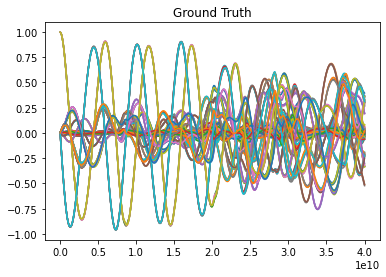

In [16]:
n_sparams = gt_data.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.plot(gt_freqs, gt_data[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(gt_freqs, gt_data[i,1,:].squeeze(), label=str(i)+" Im")
if n_sparams <= 10:
    plt.legend()
plt.title("Ground Truth")
plt.show()

In [17]:
gt_mag = utils.to_mag(torch.from_numpy(gt_data))

print(gt_mag.shape)

torch.Size([136, 8000])


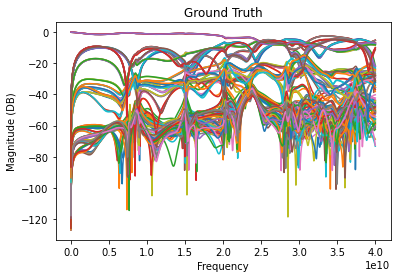

In [18]:
n_sparams = gt_mag.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.plot(gt_freqs, gt_mag[i], label=str(i))
if n_sparams <= 10:
    plt.legend()
plt.title("Ground Truth")
plt.ylabel("Magnitude (DB)")
plt.xlabel("Frequency")
plt.show()

## Check the data for some smoothness and regularity conditions

In [19]:
def calc_diffs(x, order=1):
    if order > 1:
        x = calc_diffs(x, order-1)
    
    if isinstance(x, np.ndarray):
        return (x - np.roll(x, -1, 2))[...,:-1] 
    elif torch.is_tensor(x):
        return (x - torch.roll(x, -1, 2))[...,:-1]

(136, 2, 7999)


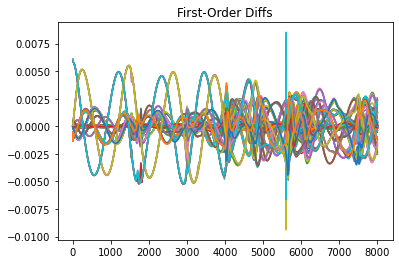

In [20]:
x_diff_1 = calc_diffs(gt_data)

print(x_diff_1.shape)

plt.figure()
for i in range(n_sparams):
    plt.plot(x_diff_1[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(x_diff_1[i,1,:].squeeze(), label=str(i)+" Im")
if n_sparams <= 10:
    plt.legend()
plt.title("First-Order Diffs")
plt.show()

(136, 2, 7998)


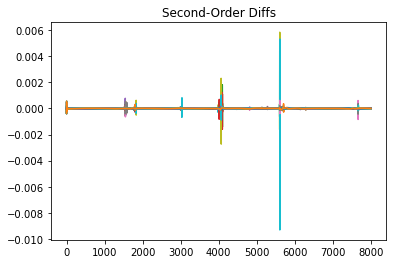

In [21]:
x_diff_2 = calc_diffs(gt_data, 2)

print(x_diff_2.shape)

plt.figure()
for i in range(n_sparams):
    plt.plot(x_diff_2[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(x_diff_2[i,1,:].squeeze(), label=str(i)+" Im")
if n_sparams <= 10:
    plt.legend()
plt.title("Second-Order Diffs")
plt.show()

## Grab some measurements

In [22]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full]
LENGTH = len(gt_freqs)
M = int(y_freqs.shape[0])

In [23]:
kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, LENGTH, M)

In [24]:
print(LENGTH)
print(M)
print(len(kept_inds))
print(len(missing_inds))

8000
38
38
7962


## Make the final data

In [25]:
x = torch.from_numpy(gt_data)
x = x.view(-1, LENGTH).unsqueeze(0)

In [26]:
print(x.shape)
print(x.dtype)

torch.Size([1, 272, 8000])
torch.float32


In [27]:
y = torch.clone(x)[:, :, kept_inds]

In [28]:
print(y.shape)
print(y.dtype)

torch.Size([1, 272, 38])
torch.float32


In [29]:
y_freqs = gt_freqs[kept_inds] #NOTE - y_freqs was previously the name of the VF used frequencies, changing it here

In [30]:
print(y_freqs.shape)
print(y_freqs.dtype)

(38,)
float64


### quick redundancy check

In [31]:
checked_inds = []
num_unique = 0
for i in range(y.shape[1]//2):
    if i in checked_inds:
        continue
    
    for j in range(y.shape[1]//2):
        if torch.mean(torch.square(y[:, i:i+2, :] - y[:, j:j+2, :])) <= 1e-10:
            checked_inds.append(j)
    
    num_unique += 1

print(num_unique * 2)

272


# Set up the network

In [32]:
LR = 1e-4 # learning rate
NUM_ITER = 10000 # number iterations

NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(LENGTH)))
NUM_LAYERS = max(NUM_LAYERS, 5)
NUM_LAYERS = min(NUM_LAYERS, 10)

# BASE_NGF = 2 ** int(np.ceil(np.log2(NZ)))
BASE_NGF = NZ
BASE_NGF = max(BASE_NGF, 128)

NGF = [int(BASE_NGF * 2**(i/2)) for i in range(NUM_LAYERS)]

BS = y.shape[0]
NC = y.shape[1]

In [33]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)

NZ:  272
NUM_LAYERS:  10
BASE NGF:  272
NGF:  [272, 384, 544, 769, 1088, 1538, 2176, 3077, 4352, 6154]
BS:  1
NC:  272


In [34]:
from models import RES_UNET

KERNEL_SIZE = 1

net = RES_UNET(bs=BS, nz=NZ, ngf=NGF, output_size=LENGTH, nc=NC, kernel_size=KERNEL_SIZE, num_layers=NUM_LAYERS)
net = net.to(device)

In [35]:
test_out = net.forward_with_z()
print(test_out.shape)

torch.Size([1, 272, 8000])


/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [36]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  425269816


# Make the linear interpolation and use it as the input to the network

In [37]:
import scipy

y_np = y.cpu().detach().numpy()

Interpolate = scipy.interpolate.interp1d(kept_inds, y_np, fill_value='extrapolate')

In [38]:
y_interp = Interpolate(np.arange(LENGTH))

print(y_interp.shape)

(1, 272, 8000)


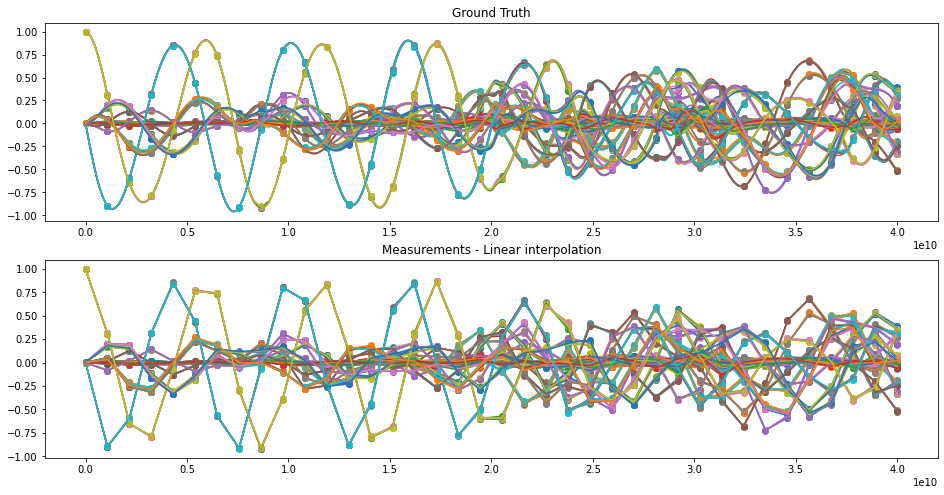

In [39]:
fig, axes = plt.subplots(2,1, figsize=(16, 8))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].flatten(), label=label)
        axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[0].set_title("Ground Truth")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, y_interp[j,i,:].flatten(), label=label)
        axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[1].set_title("Measurements - Linear interpolation")
if n_sparams <= 10:
    axes[1].legend()

plt.show()

In [40]:
y_interp_mag = utils.to_mag(torch.from_numpy(y_interp))

print(y_interp_mag.shape)

torch.Size([136, 8000])


In [41]:
x_mag = utils.to_mag(x)
y_mag = utils.to_mag(y)

print(x_mag.shape)
print(y_mag.shape)

torch.Size([136, 8000])
torch.Size([136, 38])


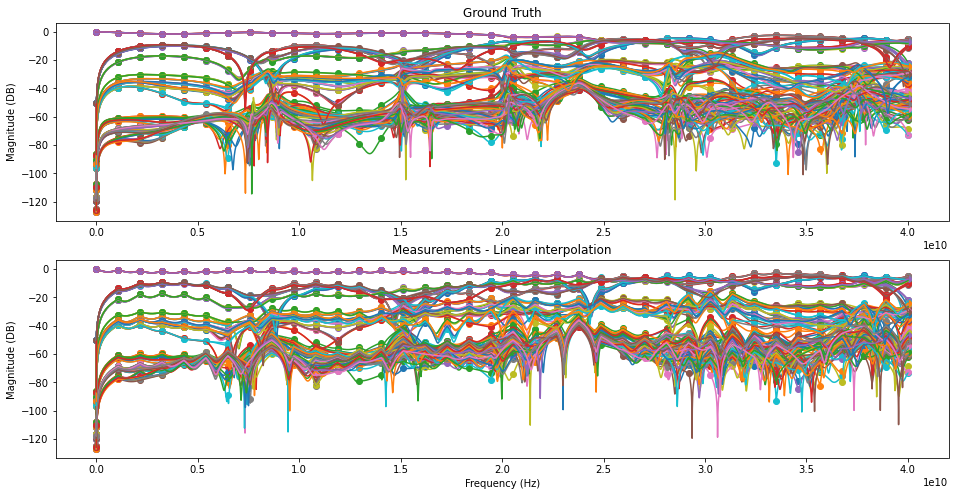

In [42]:
fig, axes = plt.subplots(2,1, figsize=(16, 8))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
    axes[0].scatter(gt_freqs[kept_inds], y_mag[j])
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs, y_interp_mag[j], label=str(j))
    axes[1].scatter(gt_freqs[kept_inds], y_mag[j])
axes[1].set_title("Measurements - Linear interpolation")
axes[1].set_ylabel("Magnitude (DB)")
axes[1].set_xlabel("Frequency (Hz)")
if n_sparams <= 10:
    axes[1].legend()

plt.show()

In [43]:
net.set_z(y_interp)

y_interp = torch.from_numpy(y_interp)
y_interp = y_interp.to(device)

# Run

In [44]:
criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=True, reduction="sum")
criterion = criterion.to(device)

regularizer = utils.Smoothing_Loss(per_param=True, reduction="sum")
regularizer = regularizer.to(device)

REG_HYPERPARAM = 25

In [45]:
net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

train_losses = []
train_errors = []
train_regs = []

test_mses = []
test_maes = []

x = x.to(device)
y = y.to(device)

In [46]:
tic = time.time()

for i in range(NUM_ITER):
    optim.zero_grad()
    
    out = net.forward_with_z()
    
    train_error = criterion(out, y) 
    train_reg = REG_HYPERPARAM * regularizer(out)
    train_loss = train_error + train_reg
    
    train_loss.backward()
    optim.step()
    
    with torch.no_grad():
        train_losses.append(train_loss.item())
        train_errors.append(train_error.item())
        train_regs.append(train_reg.item())
        
        test_mse = nn.MSELoss()(out, x)
        test_mses.append(test_mse.item())
        
        test_mae = nn.L1Loss()(out, x)
        test_maes.append(test_mae.item())

        if (i+1)%1000 == 0 or i == 0:
            toc = time.time()
            print("ITER ", str(i))
            print("TIME: ", str(toc - tic))
            print()

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


ITER  0
TIME:  0.21552348136901855

ITER  999
TIME:  130.69899654388428

ITER  1999
TIME:  261.2126634120941

ITER  2999
TIME:  391.6656446456909

ITER  3999
TIME:  522.0072612762451

ITER  4999
TIME:  652.3137676715851

ITER  5999
TIME:  782.6000020503998

ITER  6999
TIME:  913.0710527896881

ITER  7999
TIME:  1043.6980786323547

ITER  8999
TIME:  1174.3520357608795

ITER  9999
TIME:  1305.0234560966492



# Plot the last output and the metrics

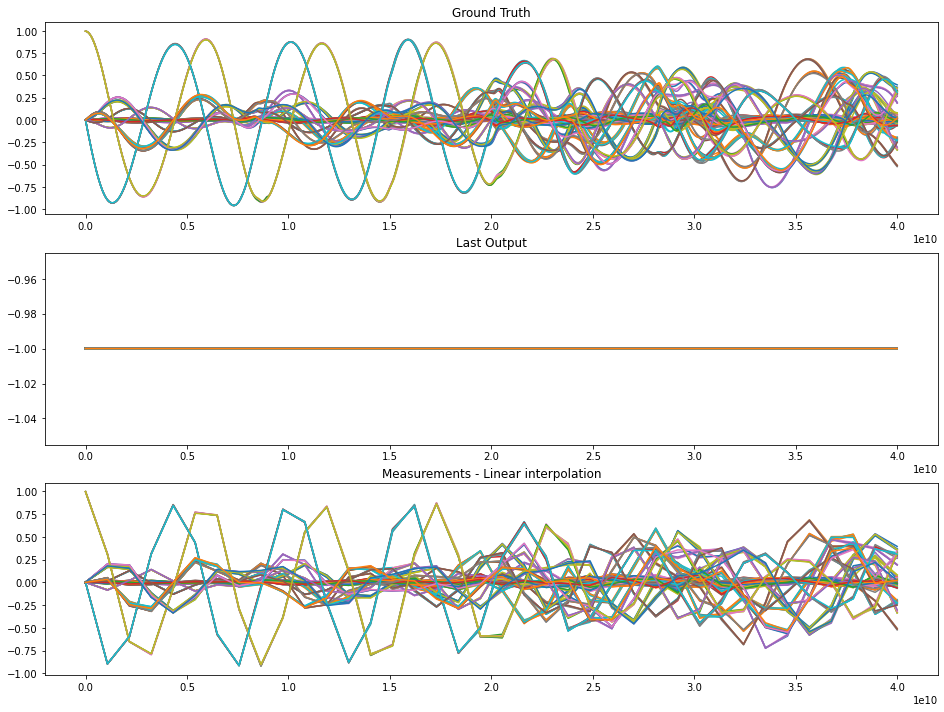

In [47]:
out = out.detach().clone().cpu()

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].cpu().flatten(), label=label)
#         axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[0].set_title("Ground Truth")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, out[j,i,:].flatten(), label=label)
#         axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[1].set_title("Last Output")
if n_sparams <= 10:
    axes[1].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[2].plot(gt_freqs[kept_inds], y[j,i,:].cpu().flatten(), label=label)
#         axes[2].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[2].set_title("Measurements - Linear interpolation")
if n_sparams <= 10:
    axes[2].legend()

plt.show()

In [48]:
out_mag = utils.to_mag(out)

print(out_mag.shape)

torch.Size([136, 8000])


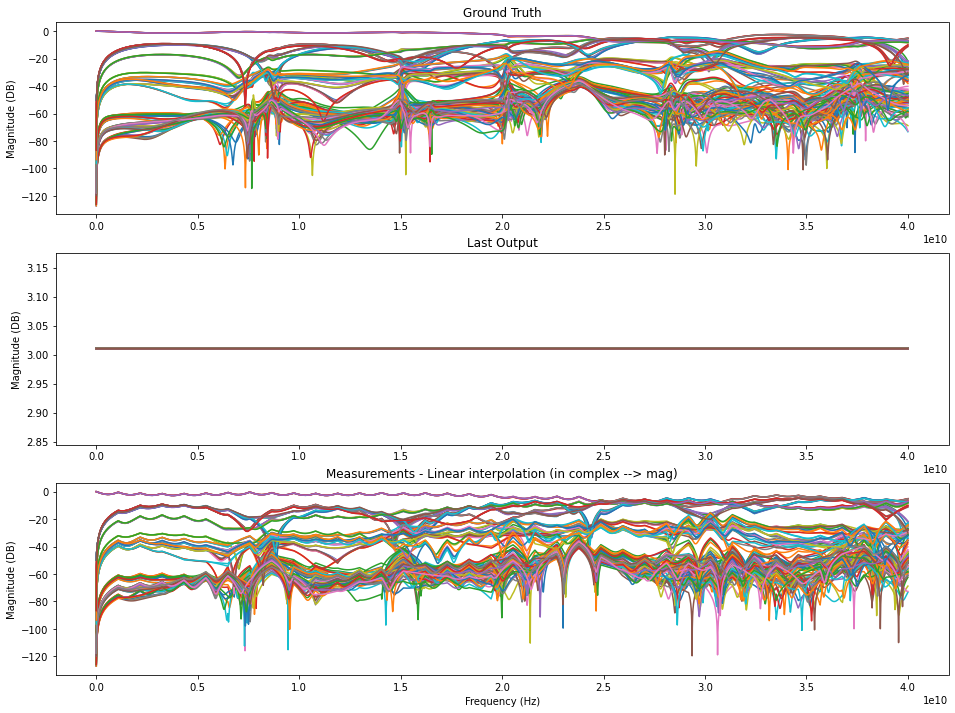

In [49]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
#     axes[0].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs, out_mag[j], label=str(j))
#     axes[1].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[1].set_title("Last Output")
axes[1].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[1].legend()

for j in range(x_mag.shape[0]):
    axes[2].plot(gt_freqs, y_interp_mag[j], label=str(j))
#     axes[2].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[2].set_title("Measurements - Linear interpolation (in complex --> mag)")
axes[2].set_ylabel("Magnitude (DB)")
axes[2].set_xlabel("Frequency (Hz)")
if n_sparams <= 10:
    axes[2].legend()

plt.show()

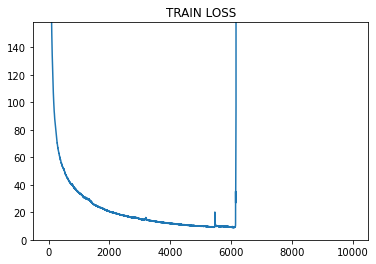

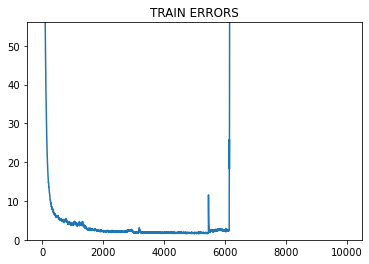

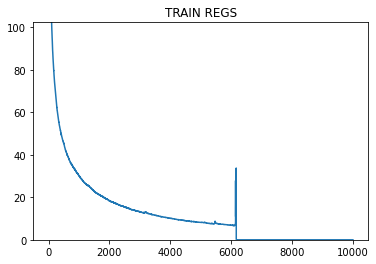

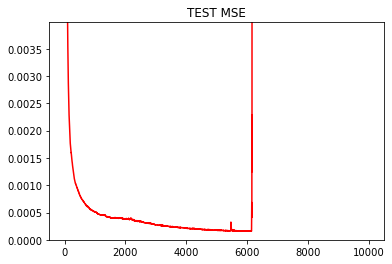

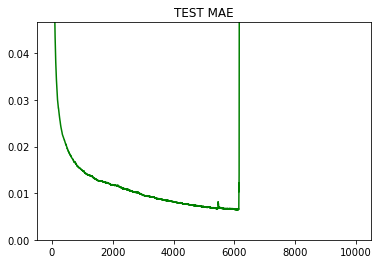

In [50]:
max_idx = 100 #np.argmax(train_losses)

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

plt.figure()
plt.plot(train_regs)
plt.title("TRAIN REGS")
plt.ylim(0., train_regs[max_idx])
plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

# Calculate Metrics between DIP, Vector Fit, Linear Interpolation, and the Ground Truth 

In [51]:
print("FINAL DIP MSE: ", test_mses[-1])
print("LINEAR INTERP MSE: ", torch.nn.MSELoss()(x, y_interp).item())

FINAL DIP MSE:  1.0249547958374023
LINEAR INTERP MSE:  0.0005646398981421804


## Make neworks from DIP, Interp, and Observations

In [52]:
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)

INTERP_MATRIX = utils.sparams_to_matrix(y_interp)

Y_MATRIX = utils.sparams_to_matrix(y)

In [53]:
print(DIP_OUT_MATRIX.shape)
print(INTERP_MATRIX.shape)
print(Y_MATRIX.shape)

torch.Size([8000, 16, 16, 2])
torch.Size([8000, 16, 16, 2])
torch.Size([38, 16, 16, 2])


In [54]:
DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(chip_num))

INTERP_net = utils.matrix_to_network(INTERP_MATRIX, gt_freqs, "Linear Interpolation With "+str(M)+" Samples for Chip "+str(chip_num))

Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(chip_num))

## Grab the data back from the networks for DIP and Interp to compare metrics

In [55]:
DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)

INTERP_FINAL_OUT = np.stack((INTERP_net.s.real, INTERP_net.s.imag), axis=-1)

In [56]:
print(DIP_FINAL_OUT.shape)
print(INTERP_FINAL_OUT.shape)

(8000, 16, 16, 2)
(8000, 16, 16, 2)


In [57]:
dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
interp_data = utils.matrix_to_sparams(INTERP_FINAL_OUT)

In [58]:
print(dip_data.shape)
print(interp_data.shape)

(136, 2, 8000)
(136, 2, 8000)


In [59]:
print(dip_data.dtype)
print(interp_data.dtype)

float32
float32


## Compare DIP, VF, and Interp

In [60]:
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

data_range = np.amax(gt_data) - np.amin(gt_data)

psnr_ours = psnr(gt_data, dip_data)#, data_range)
psnr_interp = psnr(gt_data, interp_data)#, data_range)
psnr_vf = psnr(gt_data, vf_data)#, data_range)

In [61]:
print("DIP PSNR: ", psnr_ours)
print("INTERP PSNR: ", psnr_interp)
print("VF PSNR: ", psnr_vf)

DIP PSNR:  5.913553279916409
INTERP PSNR:  38.50288428559051
VF PSNR:  41.2486317706915


## Save the outputs

In [62]:
write_path = "/scratch/04703/sravula"

DIP_net.write_touchstone(write_path+"/DIP_"+str(chip_num))
INTERP_net.write_touchstone(write_path+"/INTERP_"+str(chip_num))
Y_net.write_touchstone(write_path+"/OBSERVATIONS_"+str(chip_num))